In [74]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
import string 
import re 


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load data

In [2]:
# read sentences data
df = pd.read_excel('data/sentences_with_sentiment.xlsx')

In [8]:
df.head()

,ID,Sentence,Positive,Negative,Neutral
0,1,The results in 2nd line treatment show an ORR ...,1,0,0
1,2,The long duration of response and high durable...,1,0,0
2,3,The median OS time in the updated results exce...,0,0,1
3,4,"Therefore, the clinical benefit in 2nd line tr...",1,0,0
4,5,"The data provided in 1st line, although prelim...",1,0,0


In [42]:
# check for missing values and general info of data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 266 entries, 0 to 265
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   ID        266 non-null    int64 
 1   Sentence  266 non-null    object
 2   Positive  266 non-null    int64 
 3   Negative  266 non-null    int64 
 4   Neutral   266 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 10.5+ KB


Dataset contains onnly 266 entries making it difficult to train a deep learning model from scratch

In [ ]:
# Check how balanced the dataset classes are
df[['Positive','Negative', 'Neutral']].sum()

Positive    160
Negative     36
Neutral      70
dtype: int64

Dataset is imbalanced with a bias towards positive examples --> think about sampling strategies for training

# Clean text data

In [102]:
# all words to lower case
df['Sentence_clean'] = [text.lower() for text in df.Sentence]

# Create stopword list:
stopwords = set(STOPWORDS)

# remove stop words
df['Sentence_clean'] = [" ".join([word for word in text.split() if word not in stopwords]) for text in df.Sentence_clean]

# remove punctuation
punct = set(string.punctuation) 
df['Sentence_clean'] = ["".join([ch for ch in text if ch not in punct]) for text in df.Sentence_clean]

# remove unicode
df['Sentence_clean'] = [" ".join([word for word in text.encode(encoding="ascii", errors="ignore").decode().split()]) for text in df.Sentence_clean]

# remove numbers left over from enumeration
df['Sentence_clean'] = [re.sub(r"[0-9\n]", " ", text) for text in df.Sentence_clean]

In [116]:
# check for text duplicates with potentially different labels

df_duplicates = df.groupby('Sentence_clean').agg({'ID': 'count', 'Positive': 'sum', 'Negative': 'sum', 'Neutral': 'sum'}).reset_index()
df_duplicates = df_duplicates.loc[df_duplicates.ID > 1, :]
df_duplicates.shape[0]

22

In [119]:
# check if any of the duplicates have different labels

df_duplicates.loc[~((df_duplicates.ID == df_duplicates.Positive)|(df_duplicates.ID == df_duplicates.Neutral)|(df_duplicates.ID == df_duplicates.Negative)),:].shape[0]

0

In [120]:
# remove duplicates from data

df_no_duplicates = df.drop_duplicates(subset=['Sentence_clean'])

In [123]:
# Check how balanced the dataset classes are after dropping duplicates

df_no_duplicates[['Positive','Negative', 'Neutral']].sum()

Positive    140
Negative     30
Neutral      64
dtype: int64

Duplicates existed across all classes so dataset is still imbalanced

# Visualize data with word clouds

In [124]:
# split df - positive, neutral and negative sentiment:
positive = df_no_duplicates[df_no_duplicates['Positive'] == 1]
negative = df_no_duplicates[df_no_duplicates['Negative'] == 1]
neutral = df_no_duplicates[df_no_duplicates['Neutral'] == 1]

positive


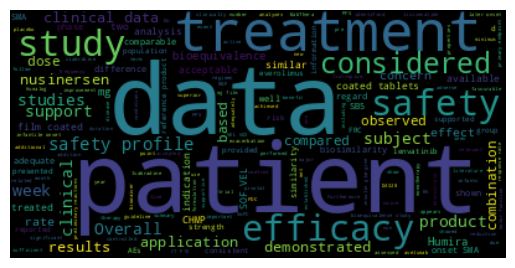

neutral


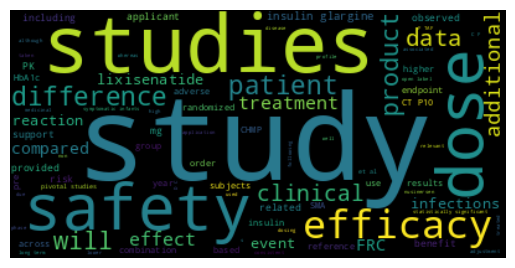

negative


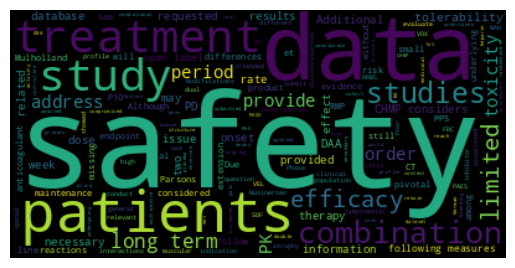

In [125]:
# Create stopword list:
stopwords = set(STOPWORDS)
stopwords.update(["br", "href"])

for data,label in [(positive, 'positive'), (neutral, 'neutral'), (negative,'negative')]:
    textt = " ".join(review for review in data.Sentence)
    wordcloud = WordCloud(stopwords=stopwords).generate(textt)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    #plt.savefig('wordcloud11.png')
    print(label)
    plt.show()

# Export clean data

In [151]:
# only keep clean sentences and sentiment for clean dataset

# aggregate sentiment in one column
df_clean = pd.melt(df_no_duplicates, id_vars=['ID', 'Sentence_clean'], value_vars=['Positive', 'Negative', 'Neutral'])
df_clean = df_clean.loc[df_clean.value == 1, :]
df_clean.drop(columns='value', inplace=True)

df_clean.rename(columns={'variable':'sentiment'}, inplace=True)


In [ ]:
#save data

df_clean.to_csv('data/Sentences_clean.csv', index=False)